# FIN41360 Assignment 1 – Data Sanity Checks

This notebook checks that the Fama–French datasets for Assignment 1 are correctly
downloaded, parsed, and aligned:

- 30 Industry Portfolios (value-weighted, monthly)
- Fama–French 3-factor model (monthly)
- Fama–French 5-factor (2x3) model (monthly)

We’ll verify shapes, sample periods, and basic summary statistics.

> EXPLAIN: This notebook is purely for validation so that we can trust the
> inputs before building mean–variance frontiers.

In [1]:
# Core imports
import pandas as pd
import numpy as np

# Local helpers for this assignment
from fin41360.process_french import (
    load_industry_30_monthly,
    load_ff3_monthly,
    load_ff5_monthly,
)

# EXPLAIN: Keeping all French-data logic in fin41360.process_french
# avoids duplicating parsing/cleaning code in notebooks.

In [2]:
# Load 30-industry value-weighted monthly gross returns
ind = load_industry_30_monthly()

# Load FF3 and FF5 factors (excess returns) + RF (gross)
ff3, rf3 = load_ff3_monthly()
ff5, rf5 = load_ff5_monthly()

print("Industries:", ind.shape, ind.index.min().date(), "→", ind.index.max().date())
print("FF3:", ff3.shape, "RF len:", len(rf3))
print("FF5:", ff5.shape, "RF len:", len(rf5))

Industries: (552, 30) 1980-01-31 → 2025-12-31
FF3: (552, 3) RF len: 552
FF5: (552, 5) RF len: 552


In [3]:
# Industry portfolios: mean and volatility
ind_stats = ind.describe().T[["mean", "std"]]
ind_stats.head()

# EXPLAIN: Values here are gross returns (R = 1 + r); for interpretation
# you may mentally subtract 1 to get net monthly returns.

,mean,std
Food,1.010910,0.041520
Beer,1.011961,0.049121
Smoke,1.014728,0.064563
Games,1.012291,0.071404
Books,1.008700,0.059752


In [ ]:
ind.head()           # first rows
ind.tail()           # last rows
ind.describe().T     # summary stats
ind.sample(10)       # random sample of rows
list(ind.columns)    # column names


['Food',
 'Beer',
 'Smoke',
 'Games',
 'Books',
 'Hshld',
 'Clths',
 'Hlth',
 'Chems',
 'Txtls',
 'Cnstr',
 'Steel',
 'FabPr',
 'ElcEq',
 'Autos',
 'Carry',
 'Mines',
 'Coal',
 'Oil',
 'Util',
 'Telcm',
 'Servs',
 'BusEq',
 'Paper',
 'Trans',
 'Whlsl',
 'Rtail',
 'Meals',
 'Fin',
 'Other']

In [ ]:
from tabulate import tabulate
print(tabulate(ind.head(20), headers="keys", tablefmt="github"))
import matplotlib.pyplot as plt

# Plot a few industry series to eyeball behaviour
ind[["Food", "Beer", "Smoke", "Games"]].iloc[:120].add(-1).plot(figsize=(10, 4))
plt.title("Selected industry net monthly returns (first 10 years)")
plt.axhline(0, color="black", linewidth=0.5)
plt.show()
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly
from fin41360.mv_frontier import compute_moments_from_gross, gmv_weights, tangency_weights, efficient_frontier

ind_gross = load_industry_30_monthly()
ind_net = ind_gross - 1.0

mu, Sigma = compute_moments_from_gross(ind_gross)

ff3, rf = load_ff3_monthly()
rf_mean = float((rf - 1.0).mean())  # average monthly RF (net)

w_gmv = gmv_weights(Sigma)
w_tan = tangency_weights(mu, Sigma, rf_mean)

target_means, vols, weights_grid = efficient_frontier(mu, Sigma)

## Scope 2 – 30-Industry MV Frontier (Sample Estimates)

The following cells construct the **unconstrained mean–variance frontier** for the
30 Fama–French industry portfolios using closed-form formulas, and identify the
GMV and tangency portfolios for Question 2(a)–(b).

> EXPLAIN: Scope 1 cells above focus on data sanity checks; scope 2 cells below
> perform the actual frontier and key-portfolio computations.

In [13]:
# Scope 2: Setup for MV frontier

import matplotlib.pyplot as plt

from fin41360.mv_frontier import (
    compute_moments_from_gross,
    gmv_weights,
    tangency_weights,
    efficient_frontier,
    portfolio_stats,
)

plt.style.use("seaborn-v0_8")  # EXPLAIN: simple, readable default style

# Use the same industry and RF data loaded above
ind_gross = ind  # (T, 30), R = 1 + r

# Re-load RF to be explicit (keeps notebook self-contained if re-run from here)
ff3_for_frontier, rf_gross_for_frontier = load_ff3_monthly()

ind_net = ind_gross - 1.0
rf_net = rf_gross_for_frontier - 1.0

print("Scope 2 sample period:")
print("Industries:", ind_net.shape, ind_net.index.min().date(), "→", ind_net.index.max().date())
print("RF:", rf_net.shape, rf_net.index.min().date(), "→", rf_net.index.max().date())

# Compute sample mean vector and covariance matrix (net monthly returns)
mu, Sigma = compute_moments_from_gross(ind_gross)

# Average monthly risk-free rate over the same sample
rf_mean = float(rf_net.mean())
print(f"Average monthly risk-free rate (net): {rf_mean:.4%}")

Scope 2 sample period:
Industries: (552, 30) 1980-01-31 → 2025-12-31
RF: (552,) 1980-01-31 → 2025-12-31
Average monthly risk-free rate (net): 0.3297%


## Scope 2B/2C – Bayes–Stein Frontiers (Means and Means+Covariance)

In this section we:

- Apply Jorion-style Bayes–Stein shrinkage to the **mean vector** of industry returns.
- Apply a **light covariance shrinkage** towards a scaled identity matrix.
- Construct three frontiers for the 30 industries:
  - **Sample**: `(mu, Sigma)`
  - **BS-mean**: `(mu_bs, Sigma)`
  - **BS-mean+cov**: `(mu_bs, Sigma_bs)`
- Compare GMV and tangency portfolios across these frontiers, focusing on
  expected excess return, volatility, and Sharpe ratio.

> EXPLAIN: We shrink towards the cross-sectional grand mean (Jorion, 1986)
> and use a modest covariance shrinkage (λ ≈ 0.1) because T >> N in our
> sample. Alternatives (e.g., constant-correlation target, Ledoit–Wolf)
> are possible but add complexity without clear benefits in this setting.

In [16]:
# Scope 2B/2C: Bayes–Stein means and covariance

from fin41360.bayes_stein import bayes_stein_means, shrink_covariance_identity
from fin41360.analyse_frontiers import compare_frontiers, print_sharpe_comparison

# We already have ind_gross, mu, Sigma, rf_net, rf_mean from earlier cells
T = ind_gross.shape[0]
N = ind_gross.shape[1]
print(f"Sample length T={T}, number of industries N={N}")

# --- Bayes–Stein shrinkage of means (towards cross-sectional grand mean) ---
bs_result = bayes_stein_means(mu, Sigma, T=T)
mu_bs = bs_result.mu_bs
print(f"Bayes–Stein shrinkage intensity (means): {bs_result.shrinkage_intensity:.3f}")
print(f"Grand mean target (monthly net): {bs_result.target_mean:.4%}")

# --- Light covariance shrinkage towards scaled identity ---
Sigma_bs = shrink_covariance_identity(Sigma, shrinkage=0.1)

# Sanity check: all covariance matrices should be symmetric and positive semi-definite
for name, S in [("sample", Sigma), ("BS-cov", Sigma_bs)]:
    eigvals = np.linalg.eigvalsh(S)
    print(f"{name} Sigma: min eigenvalue = {eigvals.min():.4e}, max = {eigvals.max():.4e}")

Sample length T=552, number of industries N=30
Bayes–Stein shrinkage intensity (means): 0.005
Grand mean target (monthly net): 1.0853%
sample Sigma: min eigenvalue = 2.9721e-04, max = 7.0464e-02
BS-cov Sigma: min eigenvalue = 6.7893e-04, max = 6.3829e-02


In [17]:
# Scope 2B/2C: Compare GMV and tangency across sample and Bayes–Stein frontiers

# Package frontier definitions in terms of (mu, Sigma)
frontiers = {
    "sample": (mu, Sigma),
    "bs_mean": (mu_bs, Sigma),
    "bs_mean_cov": (mu_bs, Sigma_bs),
}

summary = compare_frontiers(frontiers, rf_mean)
summary


,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,sample,0.009733,0.031396,0.006435,0.204973
1,TAN,sample,0.017633,0.046860,0.014336,0.305928
2,GMV,bs_mean,0.009738,0.031396,0.006441,0.205144
3,TAN,bs_mean,0.017556,0.046715,0.014259,0.305236
4,GMV,bs_mean_cov,0.010071,0.032117,0.006773,0.210897
5,TAN,bs_mean_cov,0.015950,0.043897,0.012653,0.288244


In [18]:
# Scope 2C: Rule-based commentary on Sharpe ratio changes (Question 2c)

print_sharpe_comparison(summary, base_label="sample")

[bs_mean] Tangency Sharpe change vs sample: -0.001 → Sharpe ratio is very similar to the sample-based frontier.
[bs_mean_cov] Tangency Sharpe change vs sample: -0.018 → Sharpe ratio is very similar to the sample-based frontier.


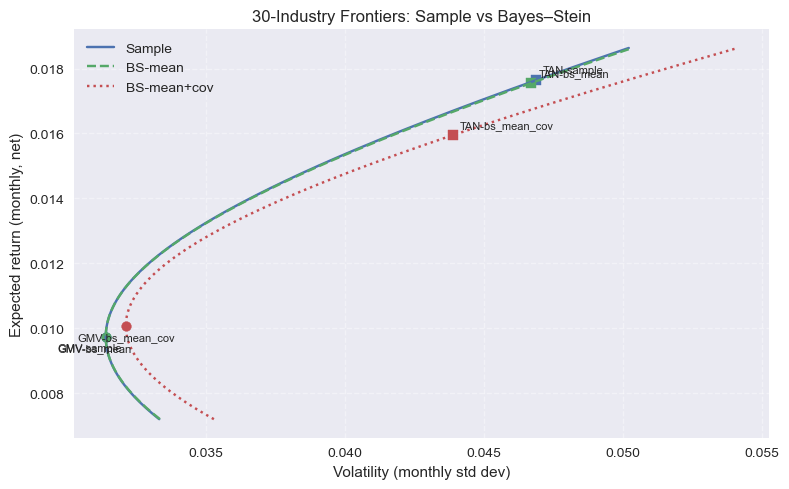

In [22]:
# Scope 2B/2C: Overlay plot of sample vs Bayes–Stein frontiers

# Use the summary table to pick a mu-range that includes GMV and TAN
# for all three frontiers, so the key portfolios lie on the plotted curves.
tan = summary[summary["portfolio"] == "TAN"].set_index("label")
gmv = summary[summary["portfolio"] == "GMV"].set_index("label")

mu_targets = np.concatenate([
    tan["mean"].values,
    gmv["mean"].values,
    mu,  # individual industry means
])
mu_min = float(mu_targets.min()) - 0.001
mu_max = float(mu_targets.max()) + 0.001

# Generate frontiers for all three (using the same mu/Sigma variants)
front_sample_means, front_sample_vols, _ = efficient_frontier(mu, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bsmean_means, front_bsmean_vols, _ = efficient_frontier(mu_bs, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bscov_means, front_bscov_vols, _ = efficient_frontier(mu_bs, Sigma_bs, n_points=200, mu_min=mu_min, mu_max=mu_max)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_sample_vols, front_sample_means, label="Sample", color="C0")
ax.plot(front_bsmean_vols, front_bsmean_means, label="BS-mean", color="C1", linestyle="--")
ax.plot(front_bscov_vols, front_bscov_means, label="BS-mean+cov", color="C2", linestyle=":")

# Highlight GMV and tangency portfolios for each frontier
for label, color in {
    "sample": "C0",
    "bs_mean": "C1",
    "bs_mean_cov": "C2",
}.items():
    # Tangency
    mu_tan_f = float(tan.loc[label, "mean"])
    vol_tan_f = float(tan.loc[label, "vol"])
    ax.scatter(vol_tan_f, mu_tan_f, color=color, marker="s")
    ax.annotate(f"TAN-{label}", (vol_tan_f, mu_tan_f), xytext=(5, 5),
                textcoords="offset points", fontsize=8)

    # GMV
    mu_gmv_f = float(gmv.loc[label, "mean"])
    vol_gmv_f = float(gmv.loc[label, "vol"])
    ax.scatter(vol_gmv_f, mu_gmv_f, color=color, marker="o")
    ax.annotate(f"GMV-{label}", (vol_gmv_f, mu_gmv_f), xytext=(-35, -10),
                textcoords="offset points", fontsize=8)

ax.set_xlabel("Volatility (monthly std dev)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("30-Industry Frontiers: Sample vs Bayes–Stein")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# EXPLAIN: By expanding the target-mean range using both GMV and tangency
# means, we ensure that all key portfolios lie on the plotted frontiers.
# This plot directly supports Question 2(c) by showing how shrinkage of
# means and covariance changes the location and shape of the efficient
# frontier and both GMV and tangency portfolios.

#TODO: Include Commentary per 2 (c)

## Scope 3 – 30 Stocks (One per Industry) and Comparison to Industries

We load monthly returns for 30 individual stocks (one per Fama–French industry),
align the sample period with the industry data so that both datasets share the same
months with no missing values, then repeat the sample and Bayes–Stein frontier
analysis on stocks and compare to the 30-industry frontiers.

In [24]:
# Scope 3: Load 30-stock monthly returns and align sample period with industries

from fin41360.stock_data import load_stock_returns_monthly, get_common_sample_period

# Load stocks over the same range we use for industries (some tickers may have shorter history)
stocks_gross = load_stock_returns_monthly(start="1980-01", end="2025-12", use_cache=True)
print("Stocks (raw):", stocks_gross.shape, stocks_gross.index.min().date(), "→", stocks_gross.index.max().date())

# Restrict to common period with no missing values in either dataset
common_start, common_end = get_common_sample_period(ind, stocks_gross)
print(f"Common sample period (no NaNs): {common_start} to {common_end}")

# TODO: find tickers which provide a longer history (see fin41360/stock_data.py).
# If the common period is short (e.g. only 2019–2025), frontier/Sharpe estimates
# will be noisier; the comparison with industries remains valid but could be
# strengthened with a longer overlap.

# Align industry and stock data to the common period
ind_common = ind.loc[common_start:common_end].dropna(how="any")
stocks_common = stocks_gross.loc[common_start:common_end].dropna(how="any")
# Sanity: same index
assert ind_common.index.equals(stocks_common.index), "Industry and stock date indices should match"
print("Aligned shapes:", ind_common.shape, stocks_common.shape)

Stocks (raw): (551, 30) 1980-01-31 → 2025-11-30
Common sample period (no NaNs): 2019-04 to 2025-11
Aligned shapes: (80, 30) (80, 30)


In [25]:
# Scope 3: Moments and Bayes–Stein for industries and stocks (common period only)

# Use the same T for both so the comparison is like-for-like
T_common = len(ind_common)
rf_common = float(rf_net.loc[ind_common.index].mean())

# Industry moments on common period
mu_ind, Sigma_ind = compute_moments_from_gross(ind_common)
bs_ind = bayes_stein_means(mu_ind, Sigma_ind, T=T_common)
Sigma_ind_bs = shrink_covariance_identity(Sigma_ind, shrinkage=0.1)

# Stock moments on common period
mu_stk, Sigma_stk = compute_moments_from_gross(stocks_common)
bs_stk = bayes_stein_means(mu_stk, Sigma_stk, T=T_common)
Sigma_stk_bs = shrink_covariance_identity(Sigma_stk, shrinkage=0.1)

print(f"Common period: {common_start} to {common_end}, T = {T_common}, rf (monthly net) = {rf_common:.4%}")
print("Industry BS shrinkage (means):", bs_ind.shrinkage_intensity)
print("Stock BS shrinkage (means):", bs_stk.shrinkage_intensity)

Common period: 2019-04 to 2025-11, T = 80, rf (monthly net) = 0.2149%
Industry BS shrinkage (means): 0.003902500292214437
Stock BS shrinkage (means): 0.007891184549728498


In [26]:
# Scope 3: Compare GMV and tangency across industries vs stocks (common period)

frontiers_ind = {
    "ind_sample": (mu_ind, Sigma_ind),
    "ind_bs_mean": (bs_ind.mu_bs, Sigma_ind),
    "ind_bs_mean_cov": (bs_ind.mu_bs, Sigma_ind_bs),
}
frontiers_stk = {
    "stk_sample": (mu_stk, Sigma_stk),
    "stk_bs_mean": (bs_stk.mu_bs, Sigma_stk),
    "stk_bs_mean_cov": (bs_stk.mu_bs, Sigma_stk_bs),
}

summary_ind = compare_frontiers(frontiers_ind, rf_common)
summary_stk = compare_frontiers(frontiers_stk, rf_common)

print("--- Industries (common period) ---")
print(summary_ind.to_string())
print("\n--- Stocks (common period) ---")
print(summary_stk.to_string())

--- Industries (common period) ---
  portfolio            label      mean       vol  excess_mean    sharpe
0       GMV       ind_sample  0.004098  0.026489     0.001949  0.073578
1       TAN       ind_sample  0.327230  0.342104     0.325081  0.950240
2       GMV      ind_bs_mean  0.004129  0.026489     0.001980  0.074748
3       TAN      ind_bs_mean  0.319723  0.335474     0.317575  0.946646
4       GMV  ind_bs_mean_cov  0.006183  0.030686     0.004034  0.131477
5       TAN  ind_bs_mean_cov  0.114173  0.161696     0.112024  0.692808

--- Stocks (common period) ---
  portfolio            label      mean       vol  excess_mean    sharpe
0       GMV       stk_sample  0.003460  0.030070     0.001311  0.043610
1       TAN       stk_sample  0.470308  0.568159     0.468159  0.823994
2       GMV      stk_bs_mean  0.003522  0.030070     0.001373  0.045674
3       TAN      stk_bs_mean  0.442262  0.538284     0.440114  0.817623
4       GMV  stk_bs_mean_cov  0.006847  0.031963     0.004698  0.1469

In [ ]:
# Scope 3: Industry vs stock comparison table (for report)

# Build a compact side-by-side comparison: industries vs stocks for each estimator
comparison_rows = []
for est in ["sample", "bs_mean", "bs_mean_cov"]:
    lab_ind = f"ind_{est}"
    lab_stk = f"stk_{est}"
    for port in ["GMV", "TAN"]:
        r_ind = summary_ind[(summary_ind["label"] == lab_ind) & (summary_ind["portfolio"] == port)].iloc[0]
        r_stk = summary_stk[(summary_stk["label"] == lab_stk) & (summary_stk["portfolio"] == port)].iloc[0]
        comparison_rows.append({
            "estimator": est,
            "portfolio": port,
            "ind_mean": r_ind["mean"],
            "stk_mean": r_stk["mean"],
            "ind_vol": r_ind["vol"],
            "stk_vol": r_stk["vol"],
            "ind_sharpe": r_ind["sharpe"],
            "stk_sharpe": r_stk["sharpe"],
        })

scope3_comparison = pd.DataFrame(comparison_rows)
scope3_comparison

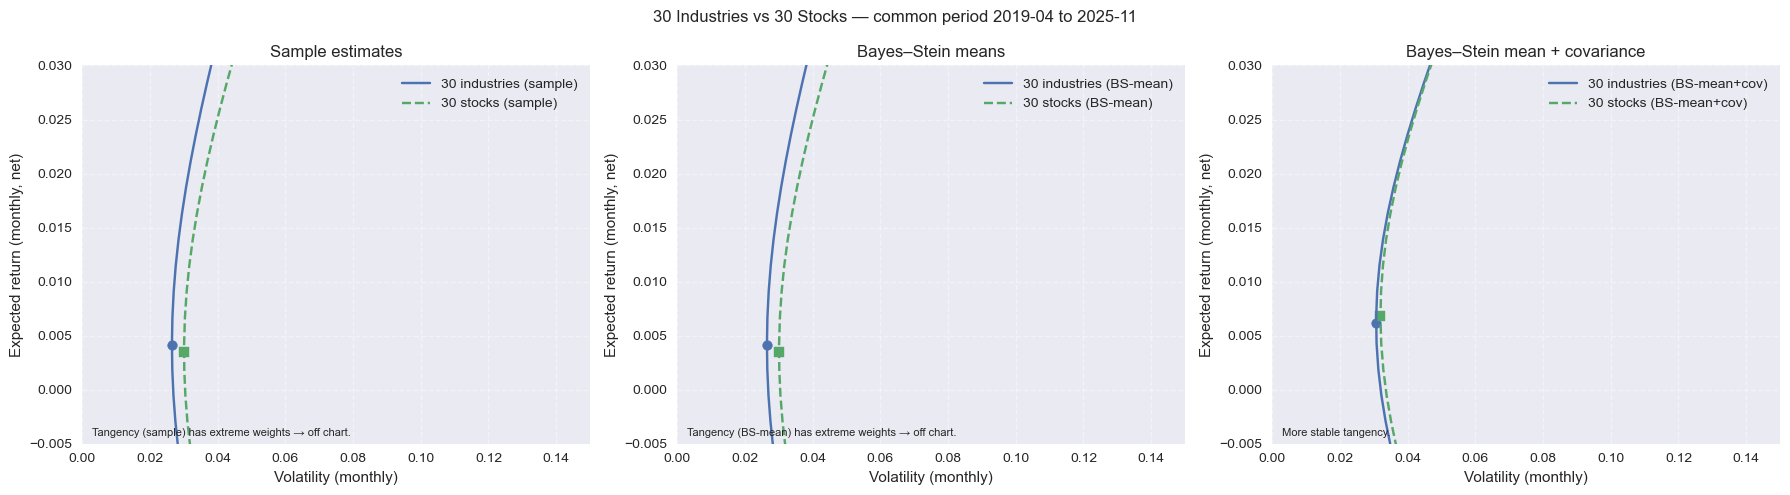

In [35]:
# Scope 3: Overlay industry vs stock frontiers (sample and BS-mean)

# Build frontier curves for the four cases we want to compare
# Same frontier construction as Scope 2: shared mean range from GMV, TAN, and asset means
# so all curves are comparable and we use n_points=200.
mu_targets_scope3 = np.concatenate([
    summary_ind["mean"].values,
    summary_stk["mean"].values,
    np.atleast_1d(mu_ind),
    np.atleast_1d(mu_stk),
    np.atleast_1d(bs_ind.mu_bs),
    np.atleast_1d(bs_stk.mu_bs),
])
scope3_mu_min = float(np.min(mu_targets_scope3)) - 0.001
scope3_mu_max = float(np.max(mu_targets_scope3)) + 0.001

def build_frontier_curve(mu, Sigma, n=200, mu_min=None, mu_max=None):
    if mu_min is None:
        mu_min = float(np.min(mu)) - 0.002
    if mu_max is None:
        mu_max = float(np.max(mu)) + 0.002
    means, vols, _ = efficient_frontier(mu, Sigma, n_points=n, mu_min=mu_min, mu_max=mu_max)
    return means, vols

m_ind_s, v_ind_s = build_frontier_curve(mu_ind, Sigma_ind, mu_min=scope3_mu_min, mu_max=scope3_mu_max)
m_stk_s, v_stk_s = build_frontier_curve(mu_stk, Sigma_stk, mu_min=scope3_mu_min, mu_max=scope3_mu_max)
m_ind_b, v_ind_b = build_frontier_curve(bs_ind.mu_bs, Sigma_ind, mu_min=scope3_mu_min, mu_max=scope3_mu_max)
m_stk_b, v_stk_b = build_frontier_curve(bs_stk.mu_bs, Sigma_stk, mu_min=scope3_mu_min, mu_max=scope3_mu_max)
m_ind_c, v_ind_c = build_frontier_curve(bs_ind.mu_bs, Sigma_ind_bs, mu_min=scope3_mu_min, mu_max=scope3_mu_max)
m_stk_c, v_stk_c = build_frontier_curve(bs_stk.mu_bs, Sigma_stk_bs, mu_min=scope3_mu_min, mu_max=scope3_mu_max)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Left: sample industry vs sample stock
ax1.plot(v_ind_s, m_ind_s, label="30 industries (sample)", color="C0")
ax1.plot(v_stk_s, m_stk_s, label="30 stocks (sample)", color="C1", linestyle="--")
for label, mu_f, Sigma_f in [("ind", mu_ind, Sigma_ind), ("stk", mu_stk, Sigma_stk)]:
    wg = gmv_weights(Sigma_f)
    wt = tangency_weights(mu_f, Sigma_f, rf_common)
    mg, vg = portfolio_stats(wg, mu_f, Sigma_f)
    mt, vt = portfolio_stats(wt, mu_f, Sigma_f)
    ax1.scatter([vg, vt], [mg, mt], color="C0" if label == "ind" else "C1", marker="o" if label == "ind" else "s")
# UNITS: Volatility and return are monthly (no annualisation). Sigma = monthly covariance; vol = sqrt(var).
# FLAT SHAPE: We clip axes so the steep part of the parabola (toward tangency) is often off-chart → flat look.
# Restrict axes to a plausible monthly range so frontiers and GMV are visible.
# Tangency (sample/BS-mean) often has extreme weights with short T → huge mean/vol, so we clip.
ax1.set_xlim(0, 0.15)
ax1.set_ylim(-0.005, 0.03)
ax1.set_xlabel("Volatility (monthly)")
ax1.set_ylabel("Expected return (monthly, net)")
ax1.set_title("Sample estimates")
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.4)
ax1.text(0.02, 0.02, "Tangency (sample) has extreme weights → off chart.", fontsize=8, transform=ax1.transAxes)

# Right: BS-mean industry vs BS-mean stock
ax2.plot(v_ind_b, m_ind_b, label="30 industries (BS-mean)", color="C0")
ax2.plot(v_stk_b, m_stk_b, label="30 stocks (BS-mean)", color="C1", linestyle="--")
for label, mu_f, Sigma_f in [("ind", bs_ind.mu_bs, Sigma_ind), ("stk", bs_stk.mu_bs, Sigma_stk)]:
    wg = gmv_weights(Sigma_f)
    wt = tangency_weights(mu_f, Sigma_f, rf_common)
    mg, vg = portfolio_stats(wg, mu_f, Sigma_f)
    mt, vt = portfolio_stats(wt, mu_f, Sigma_f)
    ax2.scatter([vg, vt], [mg, mt], color="C0" if label == "ind" else "C1", marker="o" if label == "ind" else "s")
ax2.set_xlim(0, 0.15)
ax2.set_ylim(-0.005, 0.03)
ax2.set_xlabel("Volatility (monthly)")
ax2.set_ylabel("Expected return (monthly, net)")
ax2.set_title("Bayes–Stein means")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.4)
ax2.text(0.02, 0.02, "Tangency (BS-mean) has extreme weights → off chart.", fontsize=8, transform=ax2.transAxes)

# Third: BS-mean_cov industry vs stock
ax3.plot(v_ind_c, m_ind_c, label="30 industries (BS-mean+cov)", color="C0")
ax3.plot(v_stk_c, m_stk_c, label="30 stocks (BS-mean+cov)", color="C1", linestyle="--")
for label, mu_f, Sigma_f in [("ind", bs_ind.mu_bs, Sigma_ind_bs), ("stk", bs_stk.mu_bs, Sigma_stk_bs)]:
    wg = gmv_weights(Sigma_f)
    wt = tangency_weights(mu_f, Sigma_f, rf_common)
    mg, vg = portfolio_stats(wg, mu_f, Sigma_f)
    mt, vt = portfolio_stats(wt, mu_f, Sigma_f)
    ax3.scatter([vg, vt], [mg, mt], color="C0" if label == "ind" else "C1", marker="o" if label == "ind" else "s")
ax3.set_xlim(0, 0.15)
ax3.set_ylim(-0.005, 0.03)
ax3.set_xlabel("Volatility (monthly)")
ax3.set_ylabel("Expected return (monthly, net)")
ax3.set_title("Bayes–Stein mean + covariance")
ax3.legend()
ax3.grid(True, linestyle="--", alpha=0.4)
ax3.text(0.02, 0.02, "More stable tangency.", fontsize=8, transform=ax3.transAxes)

fig.suptitle(f"30 Industries vs 30 Stocks — common period {common_start} to {common_end}")
plt.tight_layout()
plt.show()

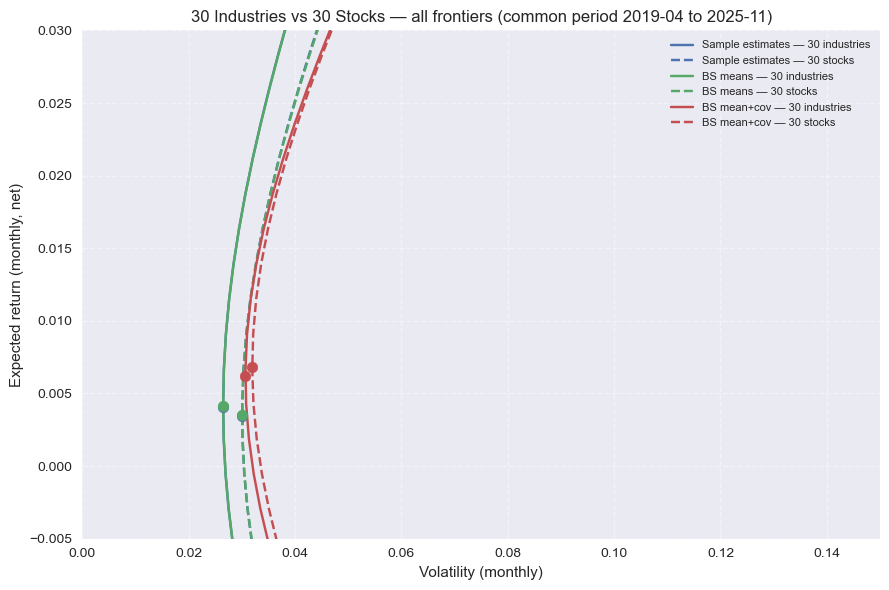

In [39]:
# Scope 3: Single-plot overlay — all three frontiers (industry & stock) with shared styling
# Reference this dict from other cells if you need consistent colours/markers elsewhere.
SCOPE3_PLOT_STYLE = {
    "estimator": {
        "sample": {"color": "C0", "label": "Sample estimates"},
        "bs_mean": {"color": "C1", "label": "BS means"},
        "bs_mean_cov": {"color": "C2", "label": "BS mean+cov"},
    },
    "universe": {
        "industry": {"linestyle": "-", "label": "30 industries"},
        "stock": {"linestyle": "--", "label": "30 stocks"},
    },
    "portfolio_marker": {"GMV": "o", "TAN": "s"},  # circle, square
}

est_curves = [
    ("sample", "industry", v_ind_s, m_ind_s), ("sample", "stock", v_stk_s, m_stk_s),
    ("bs_mean", "industry", v_ind_b, m_ind_b), ("bs_mean", "stock", v_stk_b, m_stk_b),
    ("bs_mean_cov", "industry", v_ind_c, m_ind_c), ("bs_mean_cov", "stock", v_stk_c, m_stk_c),
]

fig, ax = plt.subplots(figsize=(9, 6))
for est, univ, v, m in est_curves:
    sty_est = SCOPE3_PLOT_STYLE["estimator"][est]
    sty_univ = SCOPE3_PLOT_STYLE["universe"][univ]
    ax.plot(v, m, color=sty_est["color"], linestyle=sty_univ["linestyle"],
            label=f"{sty_est['label']} — {sty_univ['label']}")

# (mu, Sigma) per estimator × universe for GMV/TAN points
point_specs = [
    ("sample", "industry", mu_ind, Sigma_ind), ("sample", "stock", mu_stk, Sigma_stk),
    ("bs_mean", "industry", bs_ind.mu_bs, Sigma_ind), ("bs_mean", "stock", bs_stk.mu_bs, Sigma_stk),
    ("bs_mean_cov", "industry", bs_ind.mu_bs, Sigma_ind_bs), ("bs_mean_cov", "stock", bs_stk.mu_bs, Sigma_stk_bs),
]
for est, univ, mu_f, Sigma_f in point_specs:
    wg = gmv_weights(Sigma_f)
    wt = tangency_weights(mu_f, Sigma_f, rf_common)
    mg, vg = portfolio_stats(wg, mu_f, Sigma_f)
    mt, vt = portfolio_stats(wt, mu_f, Sigma_f)
    c = SCOPE3_PLOT_STYLE["estimator"][est]["color"]
    ax.scatter([vg], [mg], color=c, marker=SCOPE3_PLOT_STYLE["portfolio_marker"]["GMV"], s=60, zorder=5)
    ax.scatter([vt], [mt], color=c, marker=SCOPE3_PLOT_STYLE["portfolio_marker"]["TAN"], s=60, zorder=5)

ax.set_xlim(0, 0.15)
ax.set_ylim(-0.005, 0.03)
ax.set_xlabel("Volatility (monthly)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title(f"30 Industries vs 30 Stocks — all frontiers (common period {common_start} to {common_end})")
ax.legend(loc="best", fontsize=8)
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

Reminds me of ESG vs full universe. The frontier of a portfolio from individual stocks is going to be less diversified than the portfolio of portfolios. NOTE.

#TODO: Is there a better way to display this legend. dashed meaning stocks, full meaning industry.

**Scope 3 interpretation (Q3):**

**Why the frontiers differ:** Industry portfolios are diversified baskets of many firms, so they tend to show a better risk–return trade-off (frontier shifted left/up) than 30 individual stocks. Single-name stocks carry more **idiosyncratic risk** that is not rewarded in a mean–variance sense, so the stock frontier typically sits to the right and/or below the industry frontier. **Estimation error** is large when the number of assets is not small relative to the sample length: with a short common period (e.g. 2019–2025), sample and BS-mean tangency portfolios often have extreme weights and unrealistically high mean/vol, which is why we clip axes and note "off chart." **Bayes–Stein mean + covariance** shrinkage (BS-mean_cov) produces a more stable tangency portfolio and a plausible frontier; the third panel shows that industry vs stock comparison on this estimator. In the report, use the comparison table above and these three panels to discuss diversification, idiosyncratic risk, estimation error, and the role of BS-mean_cov.

## Scope 4 (Question 4): 30 Industries + Risk-Free Asset

We sketch the **monthly MV efficient frontier for the 30 industry portfolios and the risk-free asset** using **sample** estimates of expected returns and variance–covariance matrix. The risk-free rate is from the Fama–French factors (same data library); we use its average over the same sample period as the industry returns. The efficient set with a risk-free asset is the **capital market line (CML)** from the risk-free rate through the tangency portfolio on the risky frontier, then the upper limb of the risky frontier beyond tangency. We compare this to the **industries-only** frontier from Question 2.

Scope 4 sample period (industries and risk-free aligned):
  1980-01-31 to 2025-12-31, T = 552
  Average monthly risk-free rate (net): 0.3297%


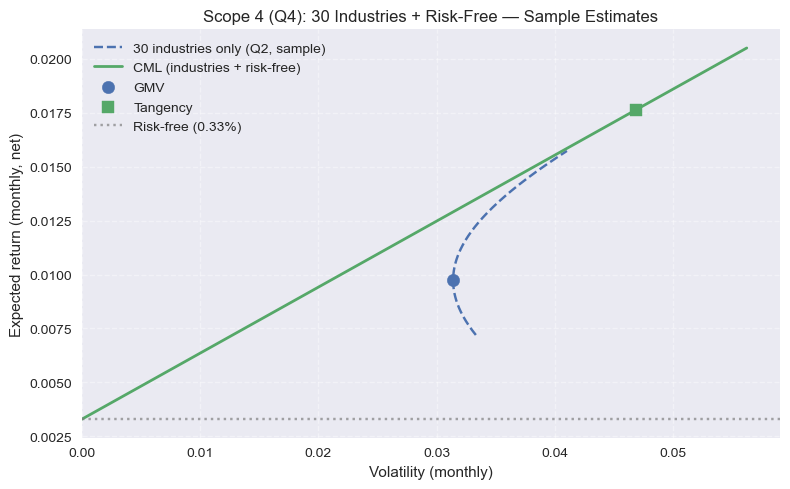


Tangency (sample): μ = 1.7633%, σ = 4.6860%, Sharpe = 0.3059
With the risk-free asset, the efficient set is the CML up to tangency, then the risky frontier above.


In [40]:
# Scope 4 (Q4): Efficient frontier for 30 industries + risk-free asset (sample estimates only)

import numpy as np
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly
from fin41360.mv_frontier import (
    compute_moments_from_gross,
    gmv_weights,
    tangency_weights,
    efficient_frontier,
    portfolio_stats,
)

# Align industry and RF to the same sample period (RF from Fama–French factors)
ind_s4 = load_industry_30_monthly()
ff3_s4, rf_gross_s4 = load_ff3_monthly()
common_idx = ind_s4.index.intersection(rf_gross_s4.index)
ind_s4 = ind_s4.loc[common_idx]
rf_net_s4 = (rf_gross_s4 - 1.0).loc[common_idx]
rf_mean_s4 = float(rf_net_s4.mean())

mu_s4, Sigma_s4 = compute_moments_from_gross(ind_s4)
T_s4 = len(ind_s4)

print("Scope 4 sample period (industries and risk-free aligned):")
print(f"  {common_idx.min().date()} to {common_idx.max().date()}, T = {T_s4}")
print(f"  Average monthly risk-free rate (net): {rf_mean_s4:.4%}")

# Risky-only frontier (30 industries, sample) — same as Q2 for comparison
mu_min_s4 = float(mu_s4.min()) - 0.001
mu_max_s4 = float(mu_s4.max()) + 0.001
front_means, front_vols, _ = efficient_frontier(mu_s4, Sigma_s4, n_points=200, mu_min=mu_min_s4, mu_max=mu_max_s4)

# Tangency portfolio (sample) and CML
w_tan_s4 = tangency_weights(mu_s4, Sigma_s4, rf_mean_s4)
mu_tan_s4, vol_tan_s4 = portfolio_stats(w_tan_s4, mu_s4, Sigma_s4)
sharpe_tan_s4 = (mu_tan_s4 - rf_mean_s4) / vol_tan_s4 if vol_tan_s4 > 0 else np.nan

# CML: mu = rf + Sharpe * vol from (0, rf) through tangency
vol_cml = np.linspace(0, float(vol_tan_s4) * 1.2, 150)
mu_cml = rf_mean_s4 + sharpe_tan_s4 * vol_cml

# GMV for reference
w_gmv_s4 = gmv_weights(Sigma_s4)
mu_gmv_s4, vol_gmv_s4 = portfolio_stats(w_gmv_s4, mu_s4, Sigma_s4)

# Plot: industries-only frontier (Q2) vs CML (industries + RF)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_vols, front_means, color="C0", linestyle="--", label="30 industries only (Q2, sample)")
ax.plot(vol_cml, mu_cml, color="C1", linewidth=2, label="CML (industries + risk-free)")
ax.scatter([vol_gmv_s4], [mu_gmv_s4], color="C0", s=80, marker="o", zorder=5, label="GMV")
ax.scatter([vol_tan_s4], [mu_tan_s4], color="C1", s=80, marker="s", zorder=5, label="Tangency")
ax.axhline(rf_mean_s4, color="gray", linestyle=":", alpha=0.7, label=f"Risk-free ({rf_mean_s4:.2%})")
ax.set_xlim(0, None)
ax.set_ylim(None, None)
ax.set_xlabel("Volatility (monthly)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("Scope 4 (Q4): 30 Industries + Risk-Free — Sample Estimates")
ax.legend(loc="best")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Compare: CML dominates the risky-only frontier below tangency; they meet at tangency.
print(f"\nTangency (sample): μ = {mu_tan_s4:.4%}, σ = {vol_tan_s4:.4%}, Sharpe = {sharpe_tan_s4:.4f}")
print("With the risk-free asset, the efficient set is the CML up to tangency, then the risky frontier above.")

**Scope 4 comparison (Q4):** The **industries-only** frontier (Q2, dashed) is the parabola of risky portfolios. Adding the **risk-free asset** gives the **CML**: the efficient set is the line from the risk-free rate through the tangency portfolio. Below tangency, the CML dominates the risky-only frontier (higher return for the same volatility). At tangency they coincide; above tangency the efficient set follows the upper limb of the risky frontier. **Sample period for the risk-free rate:** we use the same dates as the 30 industry returns (aligned intersection), so the RF sample period matches the industry sample period printed above; the average monthly risk-free rate over that period is used for the tangency portfolio and CML.

## Scope 5 (Question 5): Fama–French Factor Frontiers (FF3 and FF5)

In this section we **repeat the risk-free analysis of Question 4 using Fama–French factor-mimicking portfolios** in place of the 30 industries:

- First using the **Fama/French 3 Factors** (`Mkt-RF`, `SMB`, `HML`).
- Then using the **Fama/French 5 Factors (2x3)** (`Mkt-RF`, `SMB`, `HML`, `RMW`, `CMA`).

The factor returns are already in **excess-return format** (each column is a factor return minus the risk-free rate). To make meaningful comparisons, we also express the 30-industry portfolios in **excess-return form** (industry net return minus the risk-free rate), and we work in this excess-return space with a risk-free rate of **0**. This keeps the shapes and Sharpe ratios comparable across:

- 30 industries (excess returns)
- FF3 factor portfolios (excess returns)
- FF5 factor portfolios (excess returns)

Within each universe we:

- Compute the **sample MV frontier** (no Bayes–Stein here).
- Compute **GMV** and **tangency** portfolios and their Sharpe ratios (relative to 0 RF in excess space).
- Plot frontiers and CML-style lines (from the origin through each tangency) and **compare shapes** to the industry frontier.

In [41]:
# Scope 5 (Q5): FF3 and FF5 factor frontiers in excess-return space

import numpy as np
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly, load_ff5_monthly
from fin41360.mv_frontier import (
    compute_moments_from_net,
    efficient_frontier,
    gmv_weights,
    tangency_weights,
    portfolio_stats,
)
from fin41360.analyse_frontiers import compare_frontiers

# Load industries and FF3/FF5 factors and align to common sample
ind_5 = load_industry_30_monthly()
ff3_5, rf_gross_5 = load_ff3_monthly()
ff5_5, rf_gross_5b = load_ff5_monthly()

# Use intersection of all three indices to have a common period
common_idx_5 = ind_5.index.intersection(ff3_5.index).intersection(ff5_5.index).intersection(rf_gross_5.index)
ind_5 = ind_5.loc[common_idx_5]
ff3_5 = ff3_5.loc[common_idx_5]
ff5_5 = ff5_5.loc[common_idx_5]
rf_net_5 = (rf_gross_5.loc[common_idx_5] - 1.0)

print("Scope 5 common sample period (industries, FF3, FF5, RF aligned):")
print(f"  {common_idx_5.min().date()} to {common_idx_5.max().date()}, T = {len(common_idx_5)}")

# Express everything in excess-return form (relative to RF), and work with rf = 0 in this space.
ind_net_5 = ind_5 - 1.0
ind_excess_5 = ind_net_5.sub(rf_net_5, axis=0)

mu_ind_ex, Sigma_ind_ex = compute_moments_from_net(ind_excess_5.values)
mu_ff3_ex, Sigma_ff3_ex = compute_moments_from_net(ff3_5.values)
mu_ff5_ex, Sigma_ff5_ex = compute_moments_from_net(ff5_5.values)

# Summaries for industries vs FF3 vs FF5 (all in excess-return space, rf = 0)
frontiers_ex = {
    "industries_ex": (mu_ind_ex, Sigma_ind_ex),
    "ff3_ex": (mu_ff3_ex, Sigma_ff3_ex),
    "ff5_ex": (mu_ff5_ex, Sigma_ff5_ex),
}
summary_ex = compare_frontiers(frontiers_ex, rf=0.0)
summary_ex

Scope 5 common sample period (industries, FF3, FF5, RF aligned):
  1980-01-31 to 2025-12-31, T = 552


,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,industries_ex,0.006419,0.031293,0.006419,0.205124
1,TAN,industries_ex,0.014287,0.046686,0.014287,0.306029
2,GMV,ff3_ex,0.002523,0.019144,0.002523,0.131815
3,TAN,ff3_ex,0.005593,0.028500,0.005593,0.196232
4,GMV,ff5_ex,0.002926,0.010810,0.002926,0.270663
5,TAN,ff5_ex,0.003796,0.012313,0.003796,0.308290


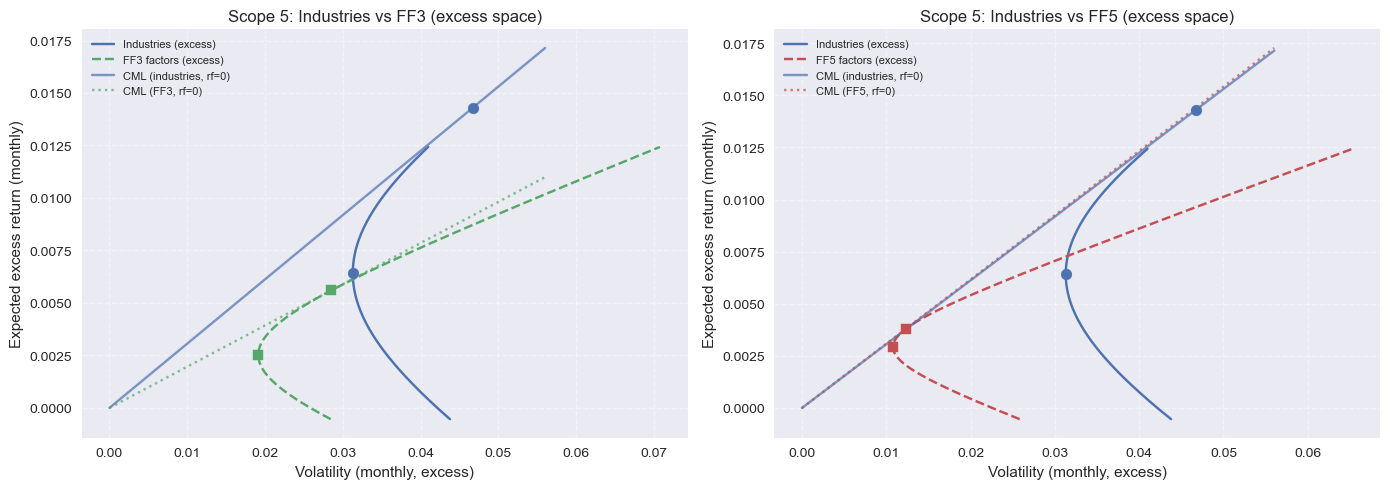

Sharpe ratios (excess space, rf=0):
  Industries: SR = 0.3060
  FF3 factors: SR = 0.1962
  FF5 factors: SR = 0.3083


In [42]:
# Scope 5: Plot frontiers and CML-style lines for industries vs FF3 vs FF5 (excess space)

# Build risky frontiers
mu_min_ex = float(min(mu_ind_ex.min(), mu_ff3_ex.min(), mu_ff5_ex.min())) - 0.001
mu_max_ex = float(max(mu_ind_ex.max(), mu_ff3_ex.max(), mu_ff5_ex.max())) + 0.001

front_ind_ex_means, front_ind_ex_vols, _ = efficient_frontier(mu_ind_ex, Sigma_ind_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)
front_ff3_ex_means, front_ff3_ex_vols, _ = efficient_frontier(mu_ff3_ex, Sigma_ff3_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)
front_ff5_ex_means, front_ff5_ex_vols, _ = efficient_frontier(mu_ff5_ex, Sigma_ff5_ex, n_points=200, mu_min=mu_min_ex, mu_max=mu_max_ex)

# GMV and tangency for each (rf = 0 in excess space)
def gmv_tan(mu, Sigma):
    w_g = gmv_weights(Sigma)
    mu_g, vol_g = portfolio_stats(w_g, mu, Sigma)
    w_t = tangency_weights(mu, Sigma, rf=0.0)
    mu_t, vol_t = portfolio_stats(w_t, mu, Sigma)
    sharpe_t = mu_t / vol_t if vol_t > 0 else np.nan
    return (mu_g, vol_g), (mu_t, vol_t, sharpe_t)

(gmv_ind, tan_ind) = gmv_tan(mu_ind_ex, Sigma_ind_ex)
(gmv_ff3, tan_ff3) = gmv_tan(mu_ff3_ex, Sigma_ff3_ex)
(gmv_ff5, tan_ff5) = gmv_tan(mu_ff5_ex, Sigma_ff5_ex)

(mu_g_ind, vol_g_ind), (mu_t_ind, vol_t_ind, sr_ind) = gmv_ind, tan_ind
(mu_g_ff3, vol_g_ff3), (mu_t_ff3, vol_t_ff3, sr_ff3) = gmv_ff3, tan_ff3
(mu_g_ff5, vol_g_ff5), (mu_t_ff5, vol_t_ff5, sr_ff5) = gmv_ff5, tan_ff5

# CML-style rays from origin in excess-return space
vol_grid = np.linspace(0, max(vol_t_ind, vol_t_ff3, vol_t_ff5) * 1.2, 150)
mu_cml_ind = sr_ind * vol_grid
mu_cml_ff3 = sr_ff3 * vol_grid
mu_cml_ff5 = sr_ff5 * vol_grid

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: industries vs FF3
ax = axes[0]
ax.plot(front_ind_ex_vols, front_ind_ex_means, color="C0", label="Industries (excess)")
ax.plot(front_ff3_ex_vols, front_ff3_ex_means, color="C1", linestyle="--", label="FF3 factors (excess)")
ax.plot(vol_grid, mu_cml_ind, color="C0", alpha=0.7, label="CML (industries, rf=0)")
ax.plot(vol_grid, mu_cml_ff3, color="C1", alpha=0.7, linestyle=":", label="CML (FF3, rf=0)")
ax.scatter([vol_g_ind, vol_t_ind], [mu_g_ind, mu_t_ind], color="C0", s=60, zorder=5, marker="o")
ax.scatter([vol_g_ff3, vol_t_ff3], [mu_g_ff3, mu_t_ff3], color="C1", s=60, zorder=5, marker="s")
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF3 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(fontsize=8)

# Right: industries vs FF5
ax = axes[1]
ax.plot(front_ind_ex_vols, front_ind_ex_means, color="C0", label="Industries (excess)")
ax.plot(front_ff5_ex_vols, front_ff5_ex_means, color="C2", linestyle="--", label="FF5 factors (excess)")
ax.plot(vol_grid, mu_cml_ind, color="C0", alpha=0.7, label="CML (industries, rf=0)")
ax.plot(vol_grid, mu_cml_ff5, color="C2", alpha=0.7, linestyle=":", label="CML (FF5, rf=0)")
ax.scatter([vol_g_ind, vol_t_ind], [mu_g_ind, mu_t_ind], color="C0", s=60, zorder=5, marker="o")
ax.scatter([vol_g_ff5, vol_t_ff5], [mu_g_ff5, mu_t_ff5], color="C2", s=60, zorder=5, marker="s")
ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF5 (excess space)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("Sharpe ratios (excess space, rf=0):")
print(f"  Industries: SR = {sr_ind:.4f}")
print(f"  FF3 factors: SR = {sr_ff3:.4f}")
print(f"  FF5 factors: SR = {sr_ff5:.4f}")

In [ ]:
# Scope 5: Single-panel overlay of industries, FF3, FF5 frontiers and CMLs (excess space)

fig, ax = plt.subplots(figsize=(9, 6))

# Risky frontiers
ax.plot(front_ind_ex_vols, front_ind_ex_means, color="C0", label="Industries (excess)")
ax.plot(front_ff3_ex_vols, front_ff3_ex_means, color="C1", linestyle="--", label="FF3 factors (excess)")
ax.plot(front_ff5_ex_vols, front_ff5_ex_means, color="C2", linestyle=":", label="FF5 factors (excess)")

# CML-style rays from origin (rf=0 in excess space)
ax.plot(vol_grid, mu_cml_ind, color="C0", alpha=0.6)
ax.plot(vol_grid, mu_cml_ff3, color="C1", alpha=0.6)
ax.plot(vol_grid, mu_cml_ff5, color="C2", alpha=0.6)

# GMV and tangency markers
ax.scatter([vol_g_ind, vol_t_ind], [mu_g_ind, mu_t_ind], color="C0", s=70, zorder=5, marker="o")
ax.scatter([vol_g_ff3, vol_t_ff3], [mu_g_ff3, mu_t_ff3], color="C1", s=70, zorder=5, marker="s")
ax.scatter([vol_g_ff5, vol_t_ff5], [mu_g_ff5, mu_t_ff5], color="C2", s=70, zorder=5, marker="^")

ax.set_xlabel("Volatility (monthly, excess)")
ax.set_ylabel("Expected excess return (monthly)")
ax.set_title("Scope 5: Industries vs FF3 vs FF5 (excess space, frontiers + CMLs)")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

print("Observation: In this common panel the CML for FF5 lies very close to the industries CML,\n"
      "indicating similar tangency Sharpe ratios, whereas the FF3 CML deviates more, reflecting\n"
      "a different risk–return trade-off for the 3-factor span.")